# Homework 5
#### Assigned: 2019-04-26
#### Due EOD: 2019-05-03

Based on Lecture 12
+ The student fills in the <...> fields.  
+ The student can create as many new cells as necessary in the solution sections.

**Make sure you have activated the correct python envorinment**

#### Name:  Xiaowen Wang
#### NetID: xw1831

## Problem 1 (20 points)

A CNN has the following structure:  

Conv2D_Layer -> Pooling_Layer -> Flattening_Layer -> Dense_Layer

+ input shape (size of the image): $M_1 \times M_2$
+ conv2d kernel with bias
+ conv2d kernel shape: $K_1 \times K_2$  
+ conv2d padding: same  
+ conv2d stride in both dimensions: 1  
+ conv2d filters (number of kernels): $F$
+ pooling layer size: $P_1 \times P_2$ (assume $P_{1,2}$ is a divisor of $M_{1,2}$) 
+ pooling padding: same
+ pooling stride in both dimensions: 1
+ flattening layer  
+ dense layer with bias
+ dense layer units (number of nodes): $H$

Write down the expression that gives the total number of parameters to be fitted $Q$ in terms of the above values.

## Solution 1

Conv2D_Layer Parameters:
$$N_1=(K_1\times K_2 +1)\times F$$
Pooling_Layer Output Shape:
$$(M_1-P_1+1)\times(M_2-P_2+1)$$
Flattening_Layer Output:
$$N_2=(M_1-P_1+1)\times(M_2-P_2+1)\times F$$
Dense_Layer Parameters:
$$N_3=H\times (N_2+1)$$
**Total number of parameters**:
\begin{equation}
\begin{aligned}
Q&=N_1+N_3\\
&=(K_1\times K_2 +1)\times F+[(M_1-P_1+1)\times(M_2-P_2+1)\times F+1]\times H\\
&=[(K_1\times K_2 +1)+(M_1-P_1+1)\times(M_2-P_2+1)\times H]\times F+H
\end{aligned}
\end{equation}

## Problem 2 (80 points) 

Use LSTM to analyze S&P 500 returns over the period 2004-2006.

The data file "stock-treasury-2004_2006.csv", to be found in the "Data" folder, contains the following:  
+ TREAS_3M: the yield of the 3-month treasury note in percent (i.e 2.1 means 2.1%)
+ Adjusted close price of ten major stocks: GM, F, UTX, CAT, MRK, PFE, IBM, MSFT, C, XOM
+ SP: The S&P 500 equity index level at the close of the trading day  

**Do the following:**  

Use the pandas read_csv function to read the Date and SP columns in a data frame called "sp_df".  
Rename the "SP" column into "ClosePx" in the same read_csv call.  
Compute the close-to-close index returns as:  $r_t = P_{t+1}/P_t - 1$ and add them as a new column "DailyRet".  
It is recommended to express all daily returns in basis points (10,000 bps = 100% = 1)

We want to train an RNN that looks back $M$ days and forecasts forward $N$ days.  
Therefore the RNN will use return sequences of size $M$, and targets of size $N$.  

Reformat the return data suitable for RNN processing as follows.  
From the "DailyRet" column of "sp_df", create a data input matrix $X$ containing rows as below:    
$$r_0, r_1, r_2, \ldots, r_{M-1}$$  
$$r_1, r_2, r_3, \ldots, r_{M}$$  
$$r_2, r_3, r_4, \ldots, r_{M+1}$$  
$$\ldots$$
From the "DailyRet" column of "sp_df", create also a target matrix $y$ containing rows as below:
$$ r_{M}, r_{M+1}, \ldots, r_{M+N-1}$$
$$ r_{M+1}, r_{M+2}, \ldots, r_{M+N}$$
$$ r_{M+2}, r_{M+3}, \ldots, r_{M+N+1}$$
$$\ldots$$

Set $M=16$ and $N=4$.  
Build an RNN with two LSTM cells and train it on the first 607 sequences.  
This means that the training set contains returns with the latest date of 2016-05-31.    
Use the remaining returns for out-of-sample testing.  
This is a regression task, so train the network using mean_squared_error loss.  
When connecting the two LSTMs, make sure you set the parameter return_sequences=True on the first LSTM, 
so that the second can see the sequences.

Compute the out-of-sample actual and predicted 2-day, 3-day, ..., N-day return, by summing 1-day forward returns up to this horizon.  
N-day return is the return from today's close to the close of the N-th day forward from today.  
Calculate and report the RMSE and the correlation between actual and predicted 1-day, 2-day, ..., N-day returns.  
Plot the actual and predicted returns in the out-of-sample part.  
What do you conclude regarding the quality of the forecasts?


## Solution 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
from sklearn.preprocessing import StandardScaler
%matplotlib inline

sp_df = pd.read_csv(os.path.join(os.getcwd(), "stock-treasury-2004_2006.csv"), usecols=[0,12],names=['Date', 'ClosePx'],header=0)

# Compute the close-to-close index returns and express all daily returns in basis points.
sp_df['DailyRet']=sp_df['ClosePx'].pct_change(1)*10000
sp_df=sp_df[1:] # Remove nan value

In [2]:
sp_df.head(5)

,Date,ClosePx,DailyRet
1,05-Jan-04,1122.22,123.953522
2,06-Jan-04,1123.67,12.920818
3,07-Jan-04,1126.33,23.672431
4,08-Jan-04,1131.92,49.630215
5,09-Jan-04,1121.86,-88.875539


### Reshape and normalize the input data

In [3]:
# Standardize Series Data due to the sensitivity of 
temp = sp_df.DailyRet.values.reshape(-1,1)
#temp = StandardScaler().fit_transform(temp)

X_size, y_size = 16, 4
X_train, y_train = [], []

# create input matrix X and target matrix y
for i in range(X_size+y_size, 607):
    X_train.append(temp[i-X_size-y_size:i-y_size,0])
    y_train.append(temp[i-y_size:i,0])

X_train, y_train = StandardScaler().fit_transform(X_train), StandardScaler().fit_transform(y_train)
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [4]:
# Check the input and output shape for LSTM.
print('The shape of input matrix X is {}'.format(X_train.shape))
print('The shape of target matrix y is {}'.format(y_train.shape))

The shape of input matrix X is (587, 16, 1)
The shape of target matrix y is (587, 4)


### Construct the LSTM

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [6]:
rnn_input_shape = (X_train.shape[1], 1)
n_units=20
rnn_drop_rate = 0.4

rnn = Sequential()
rnn.add(LSTM(input_shape=rnn_input_shape, units=n_units, activation='relu',return_sequences = True))
rnn.add(Dropout(rnn_drop_rate))
rnn.add(LSTM(input_shape=rnn_input_shape, units=n_units, activation='relu'))
rnn.add(Dropout(rnn_drop_rate))
rnn.add(Dense(4))
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16, 20)            1760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 84        
Total params: 5,124
Trainable params: 5,124
Non-trainable params: 0
_________________________________________________________________


### Compile and fit the model

In [7]:
# Not using early stopping because it would return a small value.
# from keras.callbacks import EarlyStopping
# rnn_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)

In [8]:
# compile and fit
rnn.compile(optimizer = 'nadam', loss = 'mean_squared_error')
rnn_hist = rnn.fit(X_train, y_train, epochs=300, validation_split=0.1, verbose=1)
# rnn_hist = rnn.fit(X_train, y_train, epochs=300, validation_split=0.1, callbacks=[rnn_es], verbose=1)

Train on 528 samples, validate on 59 samples
Epoch 1/300
528/528 [==============================] - 3s 5ms/step - loss: 1.0178 - val_loss: 0.8514
Epoch 2/300
528/528 [==============================] - 1s 2ms/step - loss: 1.0169 - val_loss: 0.8520
Epoch 3/300
528/528 [==============================] - 1s 1ms/step - loss: 1.0151 - val_loss: 0.8516
Epoch 4/300
528/528 [==============================] - 1s 1ms/step - loss: 1.0181 - val_loss: 0.8509
Epoch 5/300
528/528 [==============================] - 1s 979us/step - loss: 1.0157 - val_loss: 0.8507
Epoch 6/300
528/528 [==============================] - 1s 1ms/step - loss: 1.0145 - val_loss: 0.8487
Epoch 7/300
528/528 [==============================] - 0s 935us/step - loss: 1.0116 - val_loss: 0.8487
Epoch 8/300
528/528 [==============================] - 0s 938us/step - loss: 1.0134 - val_loss: 0.8461
Epoch 9/300
528/528 [==============================] - 0s 856us/step - loss: 1.0143 - val_loss: 0.8455
Epoch 10/300
528/528 [================

528/528 [==============================] - 0s 913us/step - loss: 0.9787 - val_loss: 0.8454
Epoch 80/300
528/528 [==============================] - 0s 925us/step - loss: 0.9693 - val_loss: 0.8479
Epoch 81/300
528/528 [==============================] - 0s 805us/step - loss: 0.9772 - val_loss: 0.8482
Epoch 82/300
528/528 [==============================] - 0s 891us/step - loss: 0.9744 - val_loss: 0.8486
Epoch 83/300
528/528 [==============================] - 1s 954us/step - loss: 0.9668 - val_loss: 0.8476
Epoch 84/300
528/528 [==============================] - 1s 2ms/step - loss: 0.9656 - val_loss: 0.8483
Epoch 85/300
528/528 [==============================] - 1s 2ms/step - loss: 0.9657 - val_loss: 0.8508
Epoch 86/300
528/528 [==============================] - 1s 1ms/step - loss: 0.9738 - val_loss: 0.8491
Epoch 87/300
528/528 [==============================] - 1s 1ms/step - loss: 0.9658 - val_loss: 0.8491
Epoch 88/300
528/528 [==============================] - 1s 2ms/step - loss: 0.9728 - 

528/528 [==============================] - 1s 1ms/step - loss: 0.9400 - val_loss: 0.8708
Epoch 159/300
528/528 [==============================] - 1s 2ms/step - loss: 0.9248 - val_loss: 0.8911
Epoch 160/300
528/528 [==============================] - 1s 1ms/step - loss: 0.9193 - val_loss: 0.8869
Epoch 161/300
528/528 [==============================] - 1s 1ms/step - loss: 0.9253 - val_loss: 0.8844
Epoch 162/300
528/528 [==============================] - 1s 947us/step - loss: 0.9239 - val_loss: 0.8811
Epoch 163/300
528/528 [==============================] - 1s 967us/step - loss: 0.9250 - val_loss: 0.8731
Epoch 164/300
528/528 [==============================] - 1s 997us/step - loss: 0.9108 - val_loss: 0.8947
Epoch 165/300
528/528 [==============================] - 1s 1ms/step - loss: 0.9342 - val_loss: 0.8759
Epoch 166/300
528/528 [==============================] - 1s 1ms/step - loss: 0.9278 - val_loss: 0.8898
Epoch 167/300
528/528 [==============================] - 1s 1ms/step - loss: 0.92

528/528 [==============================] - 1s 2ms/step - loss: 0.9039 - val_loss: 0.9045
Epoch 238/300
528/528 [==============================] - 1s 1ms/step - loss: 0.8874 - val_loss: 0.9028
Epoch 239/300
528/528 [==============================] - 0s 890us/step - loss: 0.8801 - val_loss: 0.9024
Epoch 240/300
528/528 [==============================] - 1s 2ms/step - loss: 0.8923 - val_loss: 0.9036
Epoch 241/300
528/528 [==============================] - 1s 1ms/step - loss: 0.8798 - val_loss: 0.9183
Epoch 242/300
528/528 [==============================] - 0s 938us/step - loss: 0.8745 - val_loss: 0.9094
Epoch 243/300
528/528 [==============================] - 1s 1ms/step - loss: 0.8823 - val_loss: 0.9263
Epoch 244/300
528/528 [==============================] - 1s 1ms/step - loss: 0.8865 - val_loss: 0.9047
Epoch 245/300
528/528 [==============================] - 1s 2ms/step - loss: 0.8996 - val_loss: 0.9083
Epoch 246/300
528/528 [==============================] - 1s 2ms/step - loss: 0.8837

### Evaluate the model

In [9]:
X_test, y_test = [], []
for i in range(X_size, len(temp[607:])-3):
    X_test.append(temp[i-X_size+607:i+607,0])
    y_test.append(temp[i+607:i+y_size+607,0])

X_test, y_test = StandardScaler().fit_transform(X_test), StandardScaler().fit_transform(y_test)
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [10]:
# Check the input and output shape for LSTM.
print('The shape of input matrix X is {}'.format(X_test.shape))
print('The shape of target matrix y is {}'.format(y_test.shape))

The shape of input matrix X is (46, 16, 1)
The shape of target matrix y is (46, 4)


In [11]:
y_pred = rnn.predict(X_test, verbose=0)
# Compute the out-of-sample actual and predicted 2-day, 3-day, ..., N-day return, 
# by summing 1-day forward returns up to this horizon.
for i in range(len(y_pred)):
    y_test[i] = y_test[i].cumsum()
    y_pred[i] = y_pred[i].cumsum()

#### RSME

In [12]:
# Calculate the RMSE between actual and predicted 1-day, 2-day, ..., N-day returns.
RMSE = []
for i in range(y_size):
    RMSE.append(np.sqrt(mean_squared_error(y_test[:,i], y_pred[:,i])))

for i in range(y_size):
    print('The '+str(i+1)+'-day RMSE between actual and predicted is {0:.4f}'.format(RMSE[i]))

The 1-day RMSE between actual and predicted is 0.9577
The 2-day RMSE between actual and predicted is 1.3235
The 3-day RMSE between actual and predicted is 1.4856
The 4-day RMSE between actual and predicted is 1.6170


#### Correlation

In [13]:
# Calculate the correlation between actual and predicted 1-day, 2-day, ..., N-day returns.
corr = []
for i in range(y_size):
    corr.append(np.corrcoef(y_test[:,i], y_pred[:,i])[0][1])

for i in range(y_size):
    print('The '+str(i+1)+'-day correlation between actual and predicted is {0:.4f}'.format(corr[i]))

The 1-day correlation between actual and predicted is 0.2899
The 2-day correlation between actual and predicted is 0.3308
The 3-day correlation between actual and predicted is 0.4062
The 4-day correlation between actual and predicted is 0.4955


#### Plotting

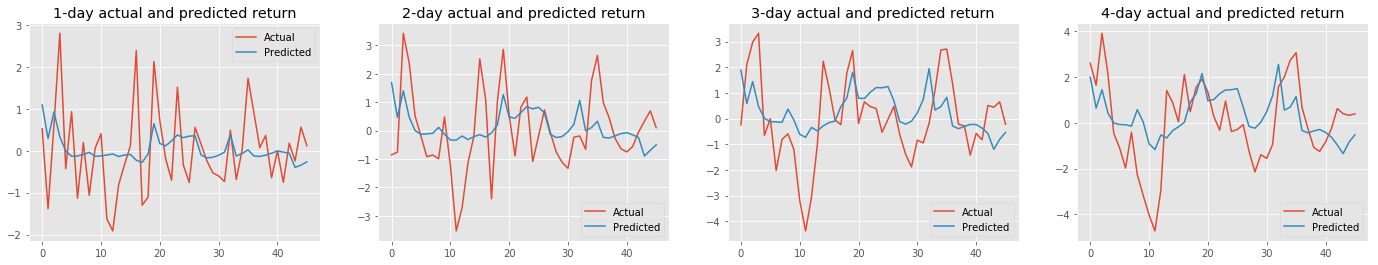

In [14]:
# Plot the actual and predicted returns in the out-of-sample part.
_, ax = plt.subplots(nrows=1, ncols=4,figsize=(24,4))
for i in range(y_size):
    ax[i].set_title(str(i+1)+'-day actual and predicted return')
    ax[i].plot(y_test[:,i],label='Actual')
    ax[i].plot(y_pred[:,i],label='Predicted')
    ax[i].legend()

## Conclusions

The quality of the prediction isn't really good. 
- The RMSE increased from 0.96 to 1.62 as the returns cumulated. However, we've scaled the returns to fit for the LSTM model and such amount of RMSE isn't actually promising. 
- The correlation grew from 0.29 to 0.50, which means the predictions of cumulative returns become more useful as time goes by but still cannot be seen as a good result.
- From the figure above, we learn that our prediciton gradually fits the actual returns as the the cumulates. However, we cannot say the quality of prediction is good. Since the stock price is stochastic, we cannot barely use the historical data to predict the future. Besides, we only have one feature to train the model, which is not enough.

Note that we've repeated several times of the LSTM model and the result above is the best we get. At most time, the correlation is worse (less than 0.2 or even 0.1). Under this situation, we don't think the model can make a prediction better than the white noise model.